In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import seals  # needed to load environments

env = gym.make("seals/CartPole-v0")
expert = PPO(
    policy=MlpPolicy,
    env=env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)
expert.learn(1000)  # Note: set to 100000 to train a proficient expert

C:\Users\mnl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mnl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [2]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    make_vec_env(
        "seals/CartPole-v0",
        n_envs=5,
        post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
        rng=rng,
    ),
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
    rng=rng,
)

C:\Users\mnl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv

import gym


venv = make_vec_env("seals/CartPole-v0", n_envs=8, rng=rng)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
)
reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
)

learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)
gail_trainer.train(20000)  # Note: set to 300000 for better results
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)

C:\Users\mnl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
round:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 500      |
|    gen/rollout/ep_rew_mean  | 31.2     |
|    gen/time/fps             | 4890     |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 16384    |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.45     |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.691    |
|    disc/disc_loss                   | 0.702    |
|    disc/disc_proportion_expert_pred | 0.95     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 1.02e+03 |
|    disc/n_generated                 | 1.02e+03 |
-

round: 100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


8.28
8.5
[8.0, 7.0, 7.0, 9.0, 8.0, 8.0, 7.0, 9.0, 9.0, 7.0, 9.0, 9.0, 8.0, 8.0, 9.0, 9.0, 8.0, 8.0, 9.0, 8.0, 8.0, 8.0, 9.0, 8.0, 9.0, 9.0, 9.0, 9.0, 7.0, 9.0, 7.0, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 8.0, 8.0, 8.0, 9.0, 8.0, 8.0, 9.0, 7.0, 8.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 7.0, 8.0, 8.0, 7.0, 9.0, 8.0, 9.0, 8.0, 8.0, 9.0, 9.0, 8.0, 9.0, 9.0, 7.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 9.0, 9.0, 8.0, 8.0, 7.0, 8.0, 9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 9.0, 8.0, 10.0, 8.0]
[8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 10.0, 9.0, 9.0, 7.0, 9.0, 9.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 7.0, 9.0, 9.0, 8.0, 9.0, 8.0, 9.0, 7.0, 9.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0, 7.0, 9.0, 8.0, 9.0, 9.0, 7.0, 9.0, 9.0, 8.0, 8.0, 9.0, 9.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 9.0, 7.0, 9.0, 8.0, 9.0, 7.0, 8.0, 8.0, 8.0, 9.0, 9.0, 8.0, 9.0, 8.0, 9.0, 10.0, 9.0, 9.0, 8.0, 9.0, 9.0, 9.0, 8.0, 9.0, 7.0, 9.0, 8

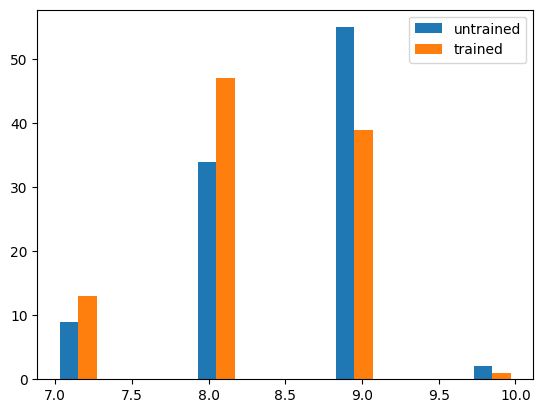

In [7]:
import matplotlib.pyplot as plt
import numpy as np

print(np.mean(learner_rewards_after_training))
print(np.mean(learner_rewards_before_training))

plt.hist(
    [learner_rewards_before_training, learner_rewards_after_training],
    label=["untrained", "trained"],
)
plt.legend()
plt.show()